In [176]:
%reload_ext autoreload
%autoreload 3

import matplotlib.pyplot as plt
from nilearn import datasets, image, plotting

import pandas as  pd
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, image, plotting
from nilearn.datasets import load_mni152_template
from nilearn.maskers.nifti_spheres_masker import _apply_mask_and_get_affinity
from nilearn.masking import intersect_masks
from src.acnets.parcellations.dosenbach import load_dosenbach2010_masker
from src.acnets.parcellations.friedman import load_fiedman2020_masker
from src.acnets.parcellations.gordon import \
    fetch_atlas as fetch_gordon2014_atlas
from src.acnets.parcellations import seitzman
from tqdm.auto import tqdm

tqdm.pandas()

In [177]:
# load MNI152 template
mni152 = load_mni152_template(resolution=2)

# load dosenbach2010
dosenbach2010_masker, dosenbach2010_labels = load_dosenbach2010_masker()
# dosenbach2010_labels['network_index'] = dosenbach2010_labels.groupby('network').ngroup()

mni152_data = mni152.get_fdata()[..., np.newaxis]
mni152 = image.new_img_like(mni152, mni152_data)

from nilearn import image

# convert to boolean
mni_data = np.where(mni152.get_fdata() > 0.0001, 1, 0).astype("int32")
mni152_mask = image.new_img_like(mni152, mni_data)

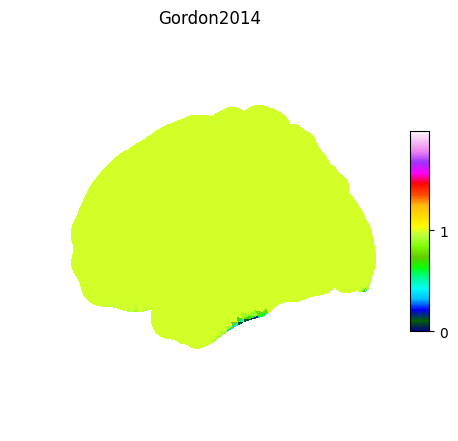

In [178]:
gordon2014_atlas = fetch_gordon2014_atlas()

from nilearn.surface import vol_to_surf

fsaverage = datasets.fetch_surf_fsaverage()
_surf = vol_to_surf(mni152_mask, fsaverage['pial_left'], radius=1)



# # DEBUG
plotting.plot_surf_roi(fsaverage['pial_left'], _surf, title='Gordon2014', colorbar=True)
plt.show()


# gordon_labels = gordon2014_atlas.labels.reset_index()
# gordon_labels['network_index'] = gordon_labels['network'].astype('category').cat.codes + 1

# gordon_network_names = gordon_labels.network.astype('category').cat.categories.to_list()

# def get_network_index(region_index):
#     net_index = 0.0
#     if region_index > 0:
#         net_index = gordon_labels[['network_index']].values[int(region_index)-1,0]
#         net_index = net_index.astype('float')

#     return net_index

# gordon_network_maps = image.load_img(gordon2014_atlas.maps).get_fdata()
# gordon_network_maps = np.vectorize(get_network_index)(gordon_network_maps)
# gordon_network_maps = image.new_img_like(gordon2014_atlas.maps, gordon_network_maps)
# gordon_network_maps = image.resample_to_img(gordon_network_maps, mni152)

In [187]:
# load masks
network = 'sensorimotor'
regions = dosenbach2010_labels.query('network == @network').copy()

seeds = regions[['x','y','z']].values
region_names = regions.index.to_list()
X, A = _apply_mask_and_get_affinity(seeds, mni152, radius=5, allow_overlap=False)

In [188]:
A_merged = A.toarray().copy()
for i in np.arange(A.shape[0]):
    A_merged[i,:] = np.where(A_merged[i,:] > 0, i, 0)

_mask = A_merged.max(axis=0).reshape(mni152.shape).astype('float')
_mask_img = image.new_img_like(mni152, _mask)

In [189]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_mesh = fsaverage.pial_left
roi_surf = vol_to_surf(_mask_img, surf_mesh, interpolation='nearest', radius=5)

gordon2014_atlas = fetch_gordon2014_atlas()
# roi_surf = vol_to_surf(gordon2014_atlas.maps, surf_mesh, interpolation='nearest', radius=5)
smn_idx = gordon2014_atlas.labels['network'].str.contains('CinguloOperc')
smn_idx = (smn_idx[smn_idx == True].index - 1).to_list()

img = image.load_img(gordon2014_atlas.maps).get_fdata()


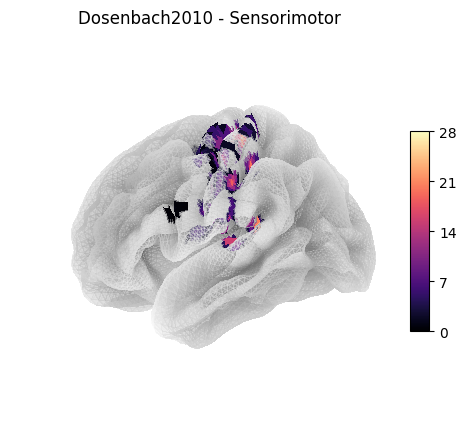

In [192]:

# # DEBUG
display = plotting.plot_surf_roi(surf_mesh, roi_surf,
                       title=f'Dosenbach2010 - Sensorimotor',
                       bg_map=fsaverage.sulc_left, bg_on_data=False,
                       alpha=.5,
                       engine='matplotlib', 
                       colorbar=True,
                       # continuous colormap: viridis, plasma, inferno, magma, cividis
                       cmap='magma',
                       view='lateral')

# cbar.set_ticklabels(region_names)

plt.show()
# 'anterior', 'posterior', 'medial', 'lateral', 'dorsal', 'ventral'